In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:

df = pd.read_csv('/content/Wholesale customers data.csv')
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:

print(df.info())


print(df.describe())

print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB
None
          Channel      Region          Fresh          Milk       Grocery  \
count  440.000000  440.000000     440.000000    440.000000    440.000000   
mean     1.322727    2.543182   12000.297727   5796.265909   7951.277273   
std      0.468052    0.774272   12647.328865   7380.377175   9503.162829   
min      1.000000    1.000000       3.000000     55.000000      3.000000   
25%      1.000000    2

Numeric columns: ['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']


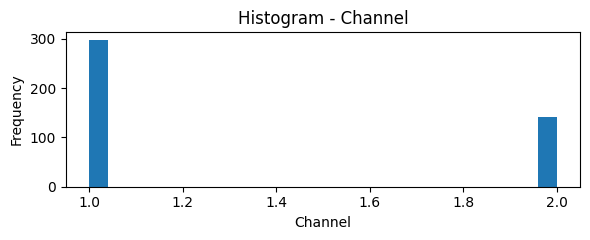

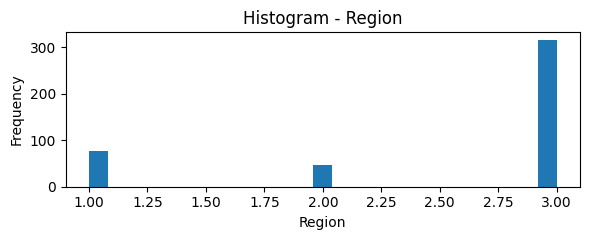

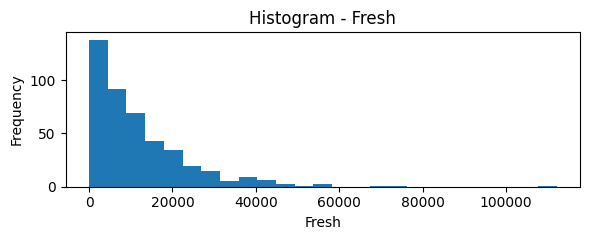

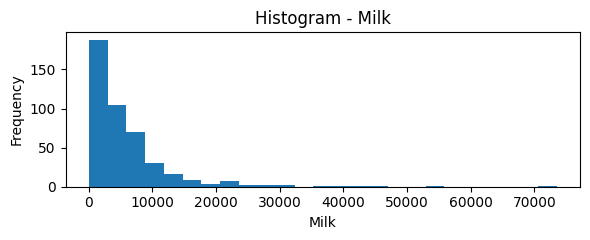

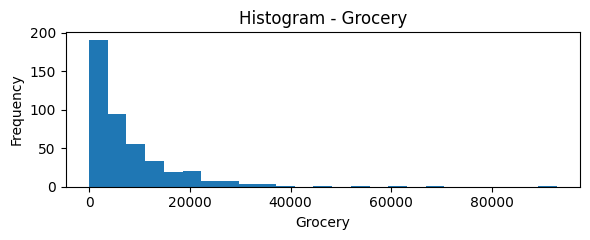

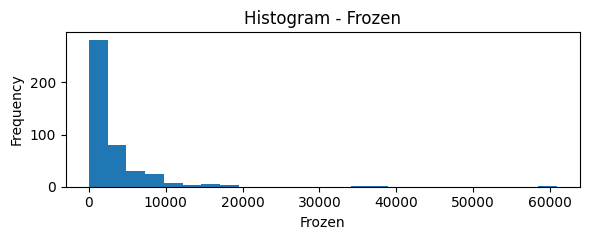

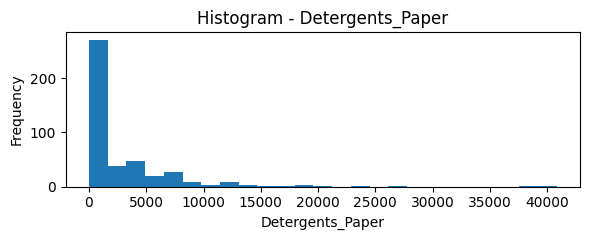

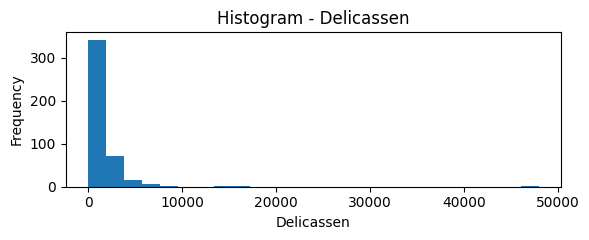

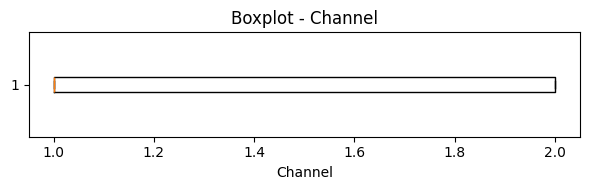

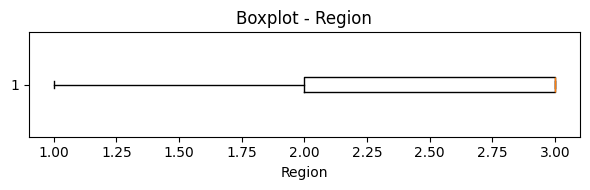

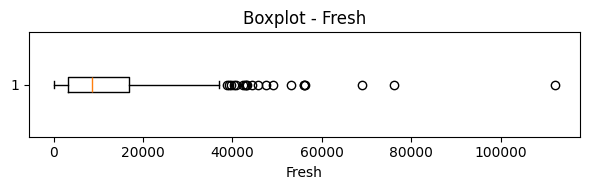

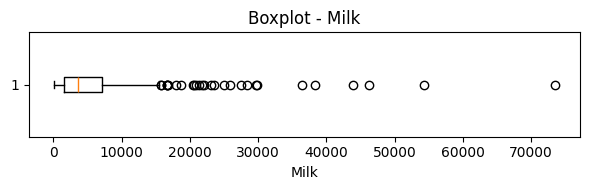

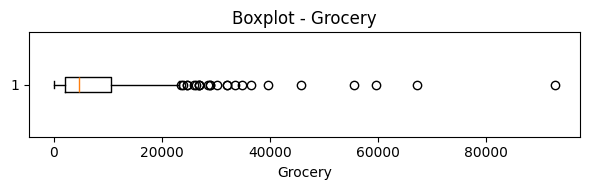

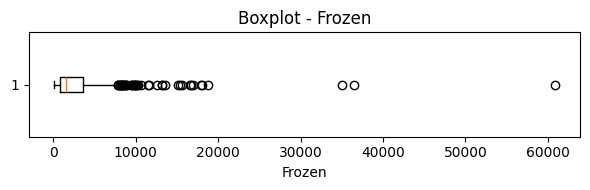

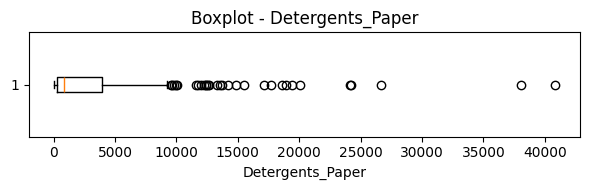

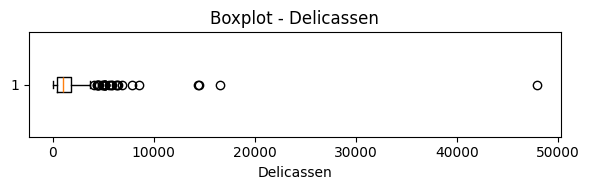

In [4]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", numeric_cols)

for col in numeric_cols:
    plt.figure(figsize=(6,2.5))
    plt.hist(df[col].dropna(), bins=25)
    plt.title(f"Histogram - {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

for col in numeric_cols:
    plt.figure(figsize=(6,2.0))
    plt.boxplot(df[col].dropna(), vert=False)
    plt.title(f"Boxplot - {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

In [6]:
from sklearn.preprocessing import StandardScaler
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
X = df[numeric_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled data shape:", X_scaled.shape)


Scaled data shape: (440, 8)


k=2  inertia=2604.41  silhouette(sampled)=0.3710
k=3  inertia=2300.26  silhouette(sampled)=0.2894
k=4  inertia=1932.24  silhouette(sampled)=0.3373
k=5  inertia=1689.19  silhouette(sampled)=0.3169
k=6  inertia=1768.36  silhouette(sampled)=0.3016


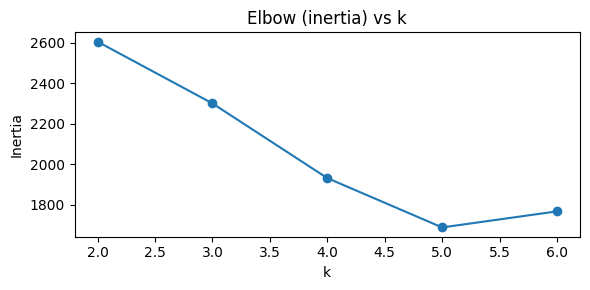

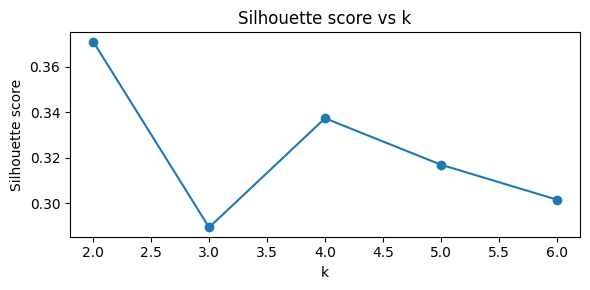

In [8]:

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

inertias = []
sil_scores = []
K_range = range(2,7)
for k in K_range:
    model = MiniBatchKMeans(n_clusters=k, random_state=42, n_init=10, batch_size=50, max_iter=300)
    labels = model.fit_predict(X_scaled)
    inertias.append(model.inertia_)

    sil = silhouette_score(X_scaled, labels, sample_size=min(300, len(X_scaled)), random_state=42)
    sil_scores.append(sil)
    print(f"k={k}  inertia={model.inertia_:.2f}  silhouette(sampled)={sil:.4f}")

plt.figure(figsize=(6,3))
plt.plot(list(K_range), inertias, marker='o')
plt.title("Elbow (inertia) vs k")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
plt.plot(list(K_range), sil_scores, marker='o')
plt.title("Silhouette score vs k")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.tight_layout()
plt.show()

In [9]:
best_k = list(K_range)[int(np.nanargmax(sil_scores))]
print("Selected best k by silhouette:", best_k)


kmeans_final = MiniBatchKMeans(n_clusters=best_k, random_state=42, n_init=10, batch_size=50, max_iter=500)
df['KMeans_Cluster'] = kmeans_final.fit_predict(X_scaled)
print("KMeans cluster counts:")
print(df['KMeans_Cluster'].value_counts().sort_index())


Selected best k by silhouette: 2
KMeans cluster counts:
KMeans_Cluster
0    302
1    138
Name: count, dtype: int64


In [11]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=best_k)
df['Agglomerative_Cluster'] = agg.fit_predict(X_scaled)
print("Agglomerative cluster counts:")
print(df['Agglomerative_Cluster'].value_counts().sort_index())

Agglomerative cluster counts:
Agglomerative_Cluster
0    142
1    298
Name: count, dtype: int64


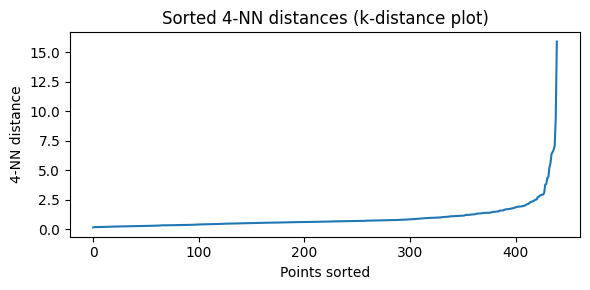

eps candidates (in scaled space): [0.6612 0.7084 0.773  0.8747 1.0508 1.2757 1.6371 2.4049]


In [14]:

from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=5).fit(X_scaled)
distances, _ = neigh.kneighbors(X_scaled)
k_dist = np.sort(distances[:, 4])


plt.figure(figsize=(6,3))
plt.plot(k_dist)
plt.title("Sorted 4-NN distances (k-distance plot)")
plt.xlabel("Points sorted")
plt.ylabel("4-NN distance")
plt.tight_layout()
plt.show()

eps_candidates = np.unique(np.percentile(k_dist, np.linspace(50, 95, 8)))
print("eps candidates (in scaled space):", np.round(eps_candidates, 4))

In [18]:
from sklearn.cluster import DBSCAN

best_eps = None
best_sil = -1
best_labels = None

for eps in eps_candidates:
    db = DBSCAN(eps=eps, min_samples=5)
    labs = db.fit_predict(X_scaled)
    n_clusters = len(set(labs)) - (1 if -1 in labs else 0)
    if n_clusters >= 2:
        sil = silhouette_score(X_scaled, labs, sample_size=min(300, len(X_scaled)), random_state=42)
        print(f"eps={eps:.4f}, clusters={n_clusters}, silhouette={sil:.4f}")
        if sil > best_sil:
            best_sil = sil
            best_eps = eps
            best_labels = labs
    else:
        print(f"eps={eps:.4f}, clusters={n_clusters} -> skip silhouette")

if best_eps is not None:
    print("Selected eps:", best_eps, "with silhouette:", best_sil)
    df['DBSCAN_Cluster'] = best_labels
else:
    # fallback if no candidate produced >=2 clusters
    print("No suitable eps found among candidates -> using default eps=0.5")
    df['DBSCAN_Cluster'] = DBSCAN(eps=0.5, min_samples=5).fit_predict(X_scaled)

print("DBSCAN label counts (including -1 for noise):")
print(df['DBSCAN_Cluster'].value_counts().sort_index())

eps=0.6612, clusters=7, silhouette=0.0497
eps=0.7084, clusters=5, silhouette=0.1419
eps=0.7730, clusters=5, silhouette=0.1604
eps=0.8747, clusters=4, silhouette=0.1823
eps=1.0508, clusters=6, silhouette=0.1417
eps=1.2757, clusters=6, silhouette=0.1730
eps=1.6371, clusters=2, silhouette=0.3528
eps=2.4049, clusters=1 -> skip silhouette
Selected eps: 1.6370618132930528 with silhouette: 0.3527822596187164
DBSCAN label counts (including -1 for noise):
DBSCAN_Cluster
-1     35
 0    126
 1    279
Name: count, dtype: int64


Explained variance ratio (2 components): [0.38750123 0.22374588]


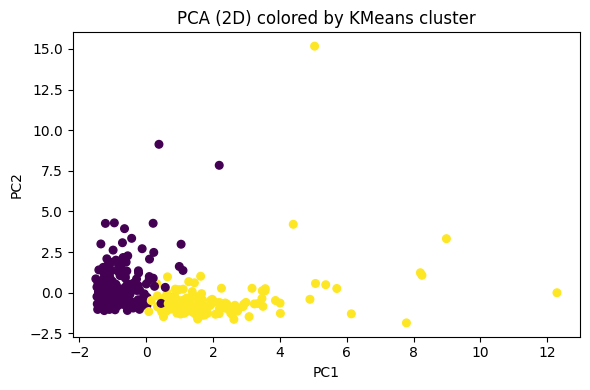

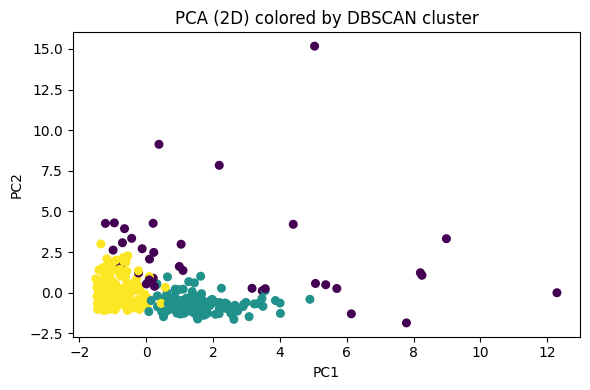

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("Explained variance ratio (2 components):", pca.explained_variance_ratio_)

plt.figure(figsize=(6,4))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df['KMeans_Cluster'], s=30)
plt.title("PCA (2D) colored by KMeans cluster")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df['DBSCAN_Cluster'], s=30)
plt.title("PCA (2D) colored by DBSCAN cluster")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.show()
